In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from utils_data_reader import get_datasets_pytorch, prep_data_range, move_alt_axis_for_numpy
from utils_plot import plot_rho_24, get_rho_at_date

# Step 1. Reading datasets.
As reading and reshaping data is relatively trivial, the modules are seprated in data_reader.py

## Data Shape Convensions
Originally, (N, 24, 20, 36) for N, lst, lat, alt. However, the paper (Briden) targets to reduce altitude and Pytorch api expectes 2nd axis to be reduced. The shape for the NN needs to be swapped.

Thus, expected shapes are (N, 36, 24, 20)

In [2]:

# Pytorch's Dataset objects. By default, reading in log10
train, val, test, original_trainset= get_datasets_pytorch(train_ds=[2011, 2012, 2013, 2014, 2015, 2016], test_ds=[2017], train_ratio=0.8, shuffle=True)



Preparing training data...
Loading data for year 2011
Loading data for year 2012
Loading data for year 2013
Loading data for year 2014
Loading data for year 2015
Loading data for year 2016
Concatenating data...
Preparing test data...
Loading data for year 2017
Concatenating data...
Train Set Shape: (41972, 36, 20, 24)
Val Set Shape:  (10492, 36, 20, 24)
Test Set Shape: (8736, 36, 20, 24)


In [3]:
class StandardScaler():
    def __init__(self, data) -> None:
        self.mean = np.mean(data)
        self.std = np.std(data)
    
    def transform(self, data):
        data = (data - self.mean) / self.std
        self.min = np.min(data)
        self.max = np.max(data)
        data = (data - self.min) / (self.max - self.min)
        return data
    
    def inverse_transform(self, data):
        data = data * (self.max - self.min) + self.min
        data = data * self.std + self.mean
        return data

ss = StandardScaler(original_trainset)

# # Now, all NN's input is scaled to [0, 1]
train.data = ss.transform(train.data)
val.data = ss.transform(val.data)
test.data = ss.transform(test.data)


# Step 2. Defining the Encoder and Decoder

In [4]:
class Encoder(nn.Module):
    def __init__(self,):
        super(Encoder, self).__init__()
        # 2D convolutional layers
        self.conv1 = nn.Conv2d(36, 5, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(5)
        self.conv2 = nn.Conv2d(5, 1, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(480, 96)
        self.fc2 = nn.Linear(96, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Fully connected layers
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 512)
        
        # 2D transposed convolutional layers, expecting: (N, 256, 1, 2) 
        self.deconv1 = nn.ConvTranspose2d(256, 82, kernel_size=5, stride=1, padding=0, output_padding=0)
        self.bn1 = nn.BatchNorm2d(82)
        self.deconv2 = nn.ConvTranspose2d(82, 60, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn2 = nn.BatchNorm2d(60)
        self.deconv3 = nn.ConvTranspose2d(60, 36, kernel_size=3, stride=2, padding=1, output_padding=1)
        # self.bn3 = nn.BatchNorm2d(36)
        # # Additional ConvTranspose2d layers
        # self.deconv4 = nn.ConvTranspose2d(36, 36, kernel_size=3, stride=1, padding=1, output_padding=0)
        # self.bn4 = nn.BatchNorm2d(36)
        # self.deconv5 = nn.ConvTranspose2d(36, 36, kernel_size=3, stride=1, padding=1, output_padding=0)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(x.size(0), 256, 1, 2)
        x = self.bn1(F.relu(self.deconv1(x)))
        x = self.bn2(F.relu(self.deconv2(x)))
        x = self.deconv3(x)
        
        # x = self.bn3(F.relu(self.deconv3(x)))
        # x = self.bn4(F.relu(self.deconv4(x)))
        # x = self.deconv5(x)

        return x

class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

### Sanity Check
Printing the data shapes layer by layer. Compare with the paper. Note that altitude axis (36) is in 2nd axis for the sake of pytorch API.

In [5]:
def trace_encoder_shapes(encoder, input_data):
    print("Tracing Encoder Shapes")
    x = input_data
    print(f'{"Input:":<25} {x.shape}')
    x = F.relu(encoder.bn1(encoder.conv1(x)))
    print(f'{"After conv1:":<25} {x.shape}')
    x = F.relu(encoder.bn2(encoder.conv2(x)))
    print(f'{"After conv2:":<25} {x.shape}')
    x = x.view(x.size(0), -1)
    print(f'{"After Flattend:":<25} {x.shape}')
    x = F.relu(encoder.fc1(x))
    print(f'{"After fc1:":<25} {x.shape}')
    x = F.relu(encoder.fc2(x))
    print(f'{"After fc2:":<25} {x.shape}')
    x = encoder.fc3(x)
    print(f'{"After fc3:":<25} {x.shape}')

def trace_decoder_shapes(decoder, encoded_data):
    print("Tracing Decoder Shapes")
    x = encoded_data
    print(f'{"Input:":<25} {x.shape}')
    x = F.relu(decoder.fc1(x))
    print(f'{"After fc1:":<25} {x.shape}')
    x = F.relu(decoder.fc2(x))
    print(f'{"After fc2:":<25} {x.shape}')
    x = x.view(x.size(0), 256, 1, 2)
    print(f'{"After Unflattend:":<25} {x.shape}')
    x = F.relu(decoder.bn1(decoder.deconv1(x)))
    print(f'{"After deconv1:":<25} {x.shape}')
    x = F.relu(decoder.bn2(decoder.deconv2(x)))
    print(f'{"After deconv2:":<25} {x.shape}')
    x = decoder.deconv3(x)
    print(f'{"After deconv3:":<25} {x.shape}')
    # x = F.relu(decoder.bn3(decoder.deconv3(x)))
    # print(f'{"After deconv3:":<25} {x.shape}')
    # x = F.relu(decoder.bn4(decoder.deconv4(x)))
    # print(f'{"After deconv4:":<25} {x.shape}')
    # x = decoder.deconv5(x)
    # print(f'{"After deconv5:":<25} {x.shape}')


# Create instances of the encoder and decoder
encoder = Encoder()
decoder = Decoder()
autoencoder = Autoencoder(encoder, decoder)

# Create a random tensor with the shape (N, 26, 24, 20)
N = 1234  # Batch size
input_data = torch.randn(N, 36, 24, 20)
encoded_data = encoder(input_data)
# Trace the shapes through the encoder and decoder
print(encoder)
trace_encoder_shapes(encoder, input_data)
print(decoder)
trace_decoder_shapes(decoder, encoded_data)    

Encoder(
  (conv1): Conv2d(36, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(5, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
Tracing Encoder Shapes
Input:                    torch.Size([1234, 36, 24, 20])
After conv1:              torch.Size([1234, 5, 24, 20])
After conv2:              torch.Size([1234, 1, 24, 20])
After Flattend:           torch.Size([1234, 480])
After fc1:                torch.Size([1234, 96])
After fc2:                torch.Size([1234, 32])
After fc3:                torch.Size([1234, 10])
Decoder(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_feat

In [68]:
class CustomLoss(nn.Module):
    def __init__(self, alpha=0.9, epsillon=1e-6):
        super(CustomLoss, self).__init__()
        self.alpha = alpha
        self.epsillon = epsillon    
        self.mse_loss = nn.MSELoss()

    def update_alpha(self, alpha):
        self.alpha = alpha

    def forward(self, y_true, y_pred, ):
        # Mean Squared Error (MSE)
        mse = self.mse_loss(y_pred, y_true)
        
        # Mean Absolute Percentage Error (MAPE)
        mape = torch.mean(torch.abs((y_true - y_pred) / (y_true + self.epsillon)))

        # print(f"MSE: {mse}, MAPE: {mape}")
        
        # Combined loss
        loss = self.alpha * mse + (1 - self.alpha) * mape
        return loss
    
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), f'./weights/autoencoder.pth')


# Step 3. Training

In [69]:
# Create instances of the encoder and decoder for this cell in the nb.
encoder = Encoder()
decoder = Decoder()
autoencoder = Autoencoder(encoder, decoder)

# double precision
double_precision = False

if double_precision:
    autoencoder = autoencoder.double()

# Define the loss function and optimizer
# criterion = nn.MSELoss()
criterion = CustomLoss(alpha=1, epsillon=1e-6)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1)

trainLoader = DataLoader(train, batch_size=64, shuffle=True)
validationLoader = DataLoader(val, batch_size=64)

# Time to move to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
autoencoder_gpu = nn.DataParallel(autoencoder).to(device)

# Training loop
num_epochs = 10**3
early_stopping = EarlyStopping(patience=10)

kp_alpha = 10**-1

for epoch in range(num_epochs):
    
    autoencoder.train()
    train_loss = 0.0
    
    for data in trainLoader:
        inputs = data.to(device) if double_precision else data.float().to(device)
        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    train_loss = train_loss / len(trainLoader.dataset)
    
    # Validation
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in validationLoader:
            inputs = data.to(device) if double_precision else data.float().to(device)
            outputs = autoencoder(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss = val_loss / len(validationLoader.dataset)

    # Update alpha. TODO: This is a very naive approach. Refactor later
    if (val_loss < 0.001):
        alpha = criterion.alpha
        new_alpha = alpha - val_loss*kp_alpha
        print(f"new_alpha: {new_alpha}")
        criterion.update_alpha(new_alpha)
    else:
        alpha = criterion.alpha
        new_alpha = alpha + val_loss*kp_alpha
        if (new_alpha > 1):
            new_alpha = 1
        print(f"new_alpha: {new_alpha}")
        criterion.update_alpha(new_alpha)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Step the scheduler
    scheduler.step(val_loss)
    
    # Check early stopping
    early_stopping(val_loss, autoencoder)
    if early_stopping.early_stop:
        print("Early stopping")
        break

torch.save(autoencoder.state_dict(), './weights/autoencoder_final.pth')

new_alpha: 1
Epoch [1/100], Train Loss: 0.1912, Validation Loss: 0.1424
new_alpha: 1
Epoch [2/100], Train Loss: 0.1159, Validation Loss: 0.0959
new_alpha: 1
Epoch [3/100], Train Loss: 0.0843, Validation Loss: 0.0743
new_alpha: 1
Epoch [4/100], Train Loss: 0.0665, Validation Loss: 0.0593
new_alpha: 1
Epoch [5/100], Train Loss: 0.0531, Validation Loss: 0.0473
new_alpha: 1
Epoch [6/100], Train Loss: 0.0425, Validation Loss: 0.0376
new_alpha: 1
Epoch [7/100], Train Loss: 0.0337, Validation Loss: 0.0300
new_alpha: 1
Epoch [8/100], Train Loss: 0.0267, Validation Loss: 0.0236
new_alpha: 1
Epoch [9/100], Train Loss: 0.0209, Validation Loss: 0.0182
new_alpha: 1
Epoch [10/100], Train Loss: 0.0158, Validation Loss: 0.0136
new_alpha: 1
Epoch [11/100], Train Loss: 0.0114, Validation Loss: 0.0094
new_alpha: 1
Epoch [12/100], Train Loss: 0.0079, Validation Loss: 0.0064
new_alpha: 1
Epoch [13/100], Train Loss: 0.0052, Validation Loss: 0.0041
new_alpha: 1
Epoch [14/100], Train Loss: 0.0033, Validation 

In [73]:
# test now
testLoader = DataLoader(test, batch_size=64)
# load weight from the last
autoencoder.load_state_dict(torch.load(f'./weights/autoencoder_final.pth'))
autoencoder.eval()
test_loss = 0.0
with torch.no_grad():
    for data in testLoader:
        inputs = data.to(device) if double_precision else data.float().to(device)
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item() * inputs.size(0)

    test_loss = test_loss / len(testLoader.dataset)

print(f"Test Loss: {test_loss:.4f}")

# get all outputs as numpy
outputs = []
with torch.no_grad():
    for data in testLoader:
        inputs = data.to(device) if double_precision else data.float().to(device)
        outputs.append(autoencoder(inputs).cpu().numpy())

outputs = np.concatenate(outputs, axis=0)   
outputs = ss.inverse_transform(outputs)
print(outputs.shape)
outputs = move_alt_axis_for_numpy(outputs)
print(outputs.shape)


Test Loss: 0.0011
(8736, 36, 20, 24)
(8736, 24, 20, 36)


# Plotting

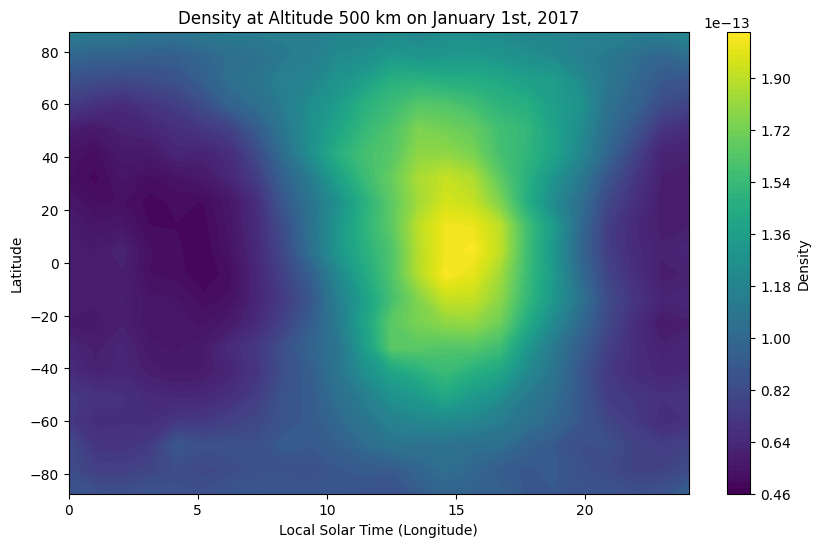

Loading data for year 2017
Concatenating data...


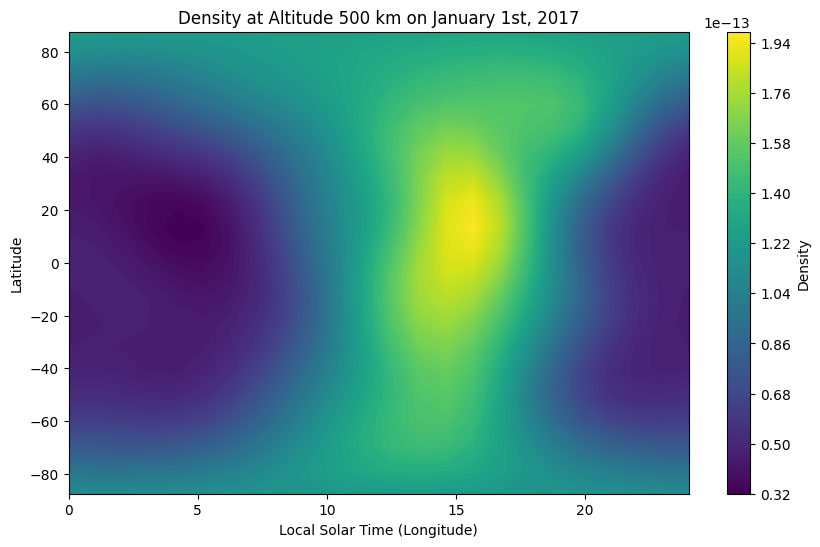

In [77]:
alt = 500

# plot predictions
rho_2017_pr = outputs
rho_2017_01_01 = get_rho_at_date(rho_2017_pr, 1, 1, 2017)
plot_rho_24(rho_2017_01_01, alt)


# plot GT
rho_2017 = prep_data_range([2017])
rho_2017_01_01 = get_rho_at_date(rho_2017, 1, 1, 2017)
plot_rho_24(rho_2017_01_01, alt)
# for i in range(100, 800, 50):
#     plot_rho_24(rho_2017_01_01, i)

